# 1. Imports

In [84]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy

In [46]:
url = 'https://raw.githubusercontent.com/michaelleejl/datasci/main/datasets/rainfall_dataset.csv'
df = pandas.read_csv(url)

rainfall = df.copy()

print([col for col in rainfall.columns])

def computeMonths(monthStr):
    yyyy = int(monthStr[:4])
    mm = (int(monthStr[5:]) -1) / 12
    return yyyy+mm

rainfall['month'] = rainfall['month'].apply(lambda x: computeMonths(x))

['month', 'total_rainfall']


# 2. Exploring Data and Initial Model

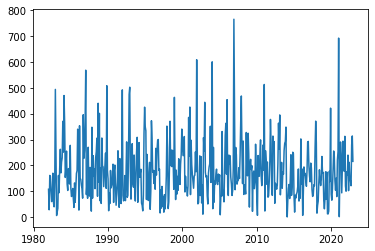

In [47]:
plt.plot(rainfall['month'], rainfall['total_rainfall'])

Idea: fit the model
$$y \sim \alpha + \beta_1 \sin(2\pi t) + \beta_2 \cos(2\pi t) + N(0, \sigma^2)$$

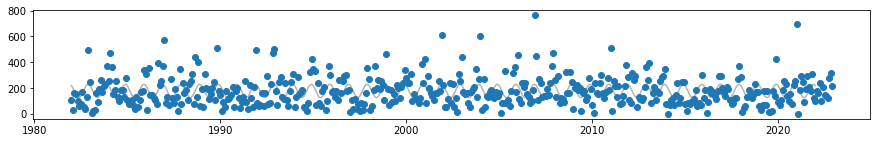

In [68]:
t = rainfall['month']
y = rainfall['total_rainfall']

model = sklearn.linear_model.LinearRegression()

features = np.column_stack([np.sin(2*np.pi*t), np.cos(2*np.pi*t)])
model.fit(features, y)

t_new = np.linspace(1982, 2022, 1000) 
x_new = np.column_stack([np.sin(2*np.pi*t_new), np.cos(2*np.pi*t_new)])
pred = model.predict(x_new)

fig, ax = plt.subplots(figsize=(15, 2))
ax.scatter(t, y)
ax.plot(t_new, pred, color='0.7', zorder = 0)

# 3. Evaluation of Initial Model

I don't like this - the model attributes (just by eyeballing it), far too much to random noise, and not enough to a deterministic trend. 

Computing a 95% confidence interval for the coefficients. A Bayesian approach

In [114]:
samples = 10000

a_samp = np.random.uniform(0, 500, size=samples)
b1_samp = np.random.uniform(-1000, 1000, size=samples)
b2_samp = np.random.uniform(-1000, 1000, size=samples)
s_samp = np.random.uniform(0, 200, size=samples)

x_samp = np.array(list(zip(a_samp, b1_samp, b2_samp, s_samp)))

In [145]:
def lik(x, t, y):
    a, b1, b2, s = x
    return np.sum(scipy.stats.norm.logpdf(y, loc=a+b1*np.sin(2*np.pi*t)+b2*np.cos(2*np.pi*t), scale=s))
w = [lik(x, t, y) for x in x_samp]
w_max = np.max(w)

In [146]:
w = np.array(w)
w_max = np.max(w)
w = np.exp(w - w_max) / (np.sum(np.exp(w - w_max)))
a, b1, b2, s = map(np.array, (map(list, zip(*x_samp))))

def ci(z, w):
    i = np.argsort(z)
    w, z = w[i], z[i]
    F = np.cumsum(w)
    return (z[F < 0.025][-1], z[F > 0.975][0])

print(ci(a, w))
print(ci(b1, w))
print(ci(b2, w))
print(ci(s, w))

(206.0406424931064, 232.23684091033093)
(-46.30336158284547, 3.42332975434374)
(-12.797950300181128, 112.48427029878849)
(106.68563055211193, 125.88453840360916)


A frequentist approach, parametric resampling

In [147]:
#define the readout statistic
def t_(m):
    a, (b1, b2) = m.intercept_, m.coef_
    s = sklearn.metrics.mean_squared_error(m.predict(features), y)
    s = np.sqrt(s)
    return a, b1, b2, s

a, b1, b2, s = t_(model)

t = rainfall['month']
#generate synthetic datasets
def presampling():
    Y = np.random.normal(loc=a+b1*np.sin(2*np.pi*t)+b2*np.cos(2*np.pi*t), scale=s)
    model = sklearn.linear_model.LinearRegression()
    model.fit(np.column_stack([np.sin(2*np.pi*t), np.cos(2*np.pi*t)]), Y)
    return model

t__ = [t_(presampling()) for _ in range(5000)]

In [148]:
conf = [0.025, 0.975]
a, b1, b2, s = map(np.array, map(list, zip(*t__)))
a_lo, a_hi = np.quantile(a, conf)
b1_lo, b1_hi = np.quantile(b1, conf)
b2_lo, b2_hi = np.quantile(b2, conf)
s_lo, s_hi = np.quantile(s, conf)
print(a_lo, a_hi)
print(b1_lo, b1_hi)
print(b2_lo, b2_hi)
print(s_lo, s_hi)

168.15480082923534 186.98670754675226
-43.34585385253731 -16.776960794834668
28.57740419905382 55.49384069184938
107.67645399112644 108.6699155693778


A frequentist approach, non parametric resampling

In [186]:
rainfall["y"] = np.floor(rainfall["month"])
rainfall["m"] = rainfall["month"] - rainfall["y"]
months = np.sort(np.unique(rainfall["m"]))
mDist = [rainfall.loc[rainfall["m"] == month]["total_rainfall"] for month in months]
t = rainfall["month"]
def npResampling():
    y = [np.random.choice(mDist[int(i)]) for i in np.rint(rainfall["m"] * 12)]
    m = sklearn.linear_model.LinearRegression()
    m.fit(features, y)
    return m
t2__ = [t_(npResampling()) for _ in range(5000)]

conf = [0.025, 0.975]
a, b1, b2, s = map(np.array, map(list, zip(*t2__)))
a_lo, a_hi = np.quantile(a, conf)
b1_lo, b1_hi = np.quantile(b1, conf)
b2_lo, b2_hi = np.quantile(b2, conf)
s_lo, s_hi = np.quantile(s, conf)
print(a_lo, a_hi)
print(b1_lo, b1_hi)
print(b2_lo, b2_hi)
print(s_lo, s_hi)

169.22323678861784 186.35062499999995
-40.90521578837816 -19.07278872588336
28.26944011731306 55.359320355237934
107.66890437001325 108.5998273305101


In [49]:
df.sort_values('total_rainfall')

month  total_rainfall
385  2014-02             0.2
469  2021-02             1.0
13   1983-02             5.6
410  2016-03             6.2
337  2010-02             6.3
..       ...             ...
60   1987-01           568.6
264  2004-01           600.9
239  2001-12           609.0
468  2021-01           692.8
299  2006-12           765.9

[492 rows x 2 columns]

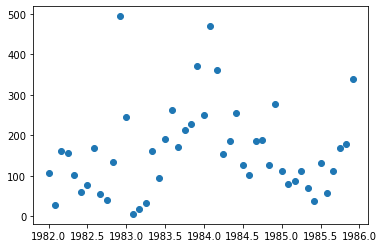

In [67]:
plt.scatter(rainfall[:48]['month'], rainfall[:48]['total_rainfall'])

The periodic trend seems to be weak

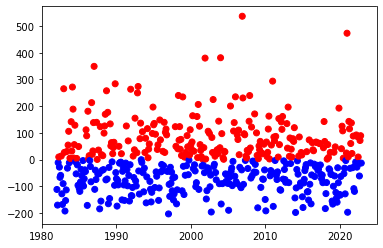

In [73]:
pred = model.predict(features)
res = y - pred
plt.scatter(t, res, c=np.where(res<=0,'blue','red'))

# 4. One Hot Linear Model

In [192]:
new_features = [np.where(rainfall["m"]==month, 1, 0) for month in months[:-1]]
model3 = sklearn.linear_model.LinearRegression()
model3.fit(np.column_stack(new_features), y)
print(model3.intercept_)
print(model3.coef_)

#interpretation of parameters: intercept is the average december rainfall. The coefficients measure the
#relative difference between rainfall in that month and rainfall in december

308.7195121951219
[ -74.42439024 -204.8        -147.81463415 -150.23902439 -142.49756098
 -173.53902439 -161.33170732 -159.29512195 -162.07317073 -146.13170732
  -51.14390244]


# 5. Hypothesis Testing

I wonder if the average rainfall in 1997 is significantly lower than other years. 

To test this theory, I shall perform a one-tailed (left tailed) hypothesis test at the 5% significance level. 

$H_0:$ The average rainfall in each year draws from the same distribution, $N(\mu, \sigma^2)$


In [223]:
years = np.sort(np.unique(rainfall["y"]))
ave_yearly_rainfall = [np.mean(rainfall.loc[rainfall["y"] == year]['total_rainfall']) for year in years]
print(ave_yearly_rainfall)
def readout(a):
    return a[15] - np.mean(np.concatenate([a[:15], a[16:]]))

def f(x):
    mu, sigma = x
    return np.sum(scipy.stats.norm.logpdf(ave_yearly_rainfall, loc=mu, scale=sigma))

def parameter_transform(x):
    nu, tau = x
    return np.exp(nu), np.exp(tau)

nuhat, tauhat = scipy.optimize.fmin(lambda x: -f(parameter_transform(x)), [10, 10])
muhat, sigmahat = np.exp(nuhat), np.exp(tauhat)
print(muhat, sigmahat)

[131.8083333333333, 166.14166666666665, 223.89166666666665, 123.65833333333335, 211.34166666666667, 175.23333333333335, 216.55000000000004, 205.26666666666665, 126.98333333333335, 156.41666666666666, 188.4, 180.725, 161.8166666666667, 194.38333333333333, 201.49999999999997, 93.24166666666667, 218.59166666666667, 177.83333333333334, 197.54166666666666, 231.92499999999998, 145.74166666666667, 199.26666666666668, 178.03333333333333, 160.89166666666665, 229.4333333333333, 240.51666666666668, 193.75833333333333, 160.075, 172.92499999999998, 210.35000000000002, 179.99166666666667, 229.0333333333333, 128.2, 105.59166666666668, 162.97500000000002, 170.46666666666667, 142.35, 113.95833333333333, 157.21666666666667, 234.13333333333333, 183.93333333333337]
Optimization terminated successfully.
         Current function value: 206.413401
         Iterations: 52
         Function evaluations: 96
177.61341487431312 37.17013372257632


In [224]:
c = readout(ave_yearly_rainfall)
print(c)
def synth():
    a = np.random.normal(loc=muhat, scale=sigmahat, size=len(years))
    return a

s = [readout(synth()) for _ in range(5000)]

-86.47958333333332


In [231]:
s.sort()
s = np.array(s)
i = np.mean(s <= c)
print(i)

0.011


Therefore I can conclude, at the 5% level, that the rainfall in 1997 was significantly lower than average.